In [1]:
import torch
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn as nn

from torch.distributions.multivariate_normal import MultivariateNormal
from copy import deepcopy
from tqdm.auto import trange
from scipy.stats import gaussian_kde
from mpl_toolkits import mplot3d

sys.path.append("./lib")

from sw import *
from swgf_mlp import *

from celluloid import Camera
from IPython.display import HTML

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Sliced-Wasserstein Gradient Flow with Generative Models

We focus here on aggregation type equations, i.e. which use as functional
\begin{equation}
    \mathcal{W}(\rho) = \frac12 \iint W(x-y)\rho(x)\rho(y)\mathrm{d}x\mathrm{d}y
\end{equation}

The JKO scheme is then
\begin{equation*}
    \rho_{k+1}^\tau = \mathrm{argmin}_{\rho\in\Sigma_n}\ \frac{1}{2\tau}SW_2^2(\rho,\rho_k^\tau) + \mathcal{W}(\rho).
\end{equation*}
and the PDE followed by the gradient flow is
\begin{equation}
    \frac{\partial\rho_t}{\partial t} = \mathrm{div}(\rho\nabla(W*\rho)).
\end{equation}

As the density is not require to evaluate the functional (no internal energy term), we can plug any neural network to learn the density. We will use several functionals used in section 4.3 of [1].

### MLP

In [3]:
class mlp(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

### Aggregation Equation

First, they use an interaction kernel
\begin{equation}
    W(x)=\frac{\|x\|^4}{4}-\frac{\|x\|^2}{2}
\end{equation}

The stead state is supposed to be a Dirac ring of radius $0.5$ and centered at the origin.

In [4]:
def W(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    return norm_x**4/4 - norm_x**2/2


def J(rho):
    z_1 = torch.randn(1000, 2, device=device)
    z_2 = torch.randn(1000, 2, device=device)
    
    x_1 = rho(z_1)
    x_2 = rho(z_2)
    
    ws = W(x_1-x_2[:,None])
    return torch.mean(ws)/2

In [5]:
t_init = 0
t_end = 10
h = 0.05

n_steps = int(np.ceil((t_end-t_init)/h))

d = 2

mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
sigma0 = torch.tensor(0.25**2 * np.eye(2),device=device,dtype=torch.float)
rho_0 = MultivariateNormal(mu0,sigma0)

lrs = 1e-4 * np.ones(n_steps)
lrs[0] = 5e-3

Lrho = SWGF(rho_0, h, n_step=n_steps, n_epochs=400, 
            J=J, create_nn=mlp, nh=64, nl=5, lrs=lrs, 
            num_projections=1000, n_samples=1024, 
            plot_loss=False, tqdm_bar=True)

t=18mn

In [6]:
z = torch.randn(10000, 2, device=device)
x = Lrho[-1](z)

kernel = gaussian_kde(x.T.detach().cpu())

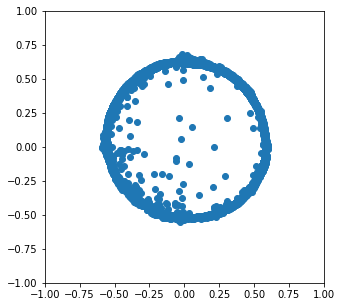

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(x.detach().cpu()[:,0], x.detach().cpu()[:,1])
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

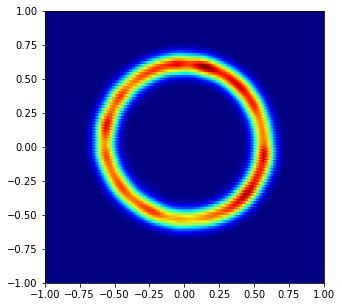

In [22]:
h = 0.125
kernel.set_bandwidth(h)

xmin, xmax, ymin, ymax = -1, 1, -1, 1

xline = np.linspace(xmin, xmax, 100)
yline = np.linspace(ymin, ymax, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],axis=1)

zz = kernel.pdf(xyinput.T)
zgrid = zz.reshape(100, 100)

plt.figure(figsize=(5,5))
plt.scatter(xyinput[:,0], xyinput[:,1], c=zz, cmap="jet")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# plt.title(h)
plt.show()

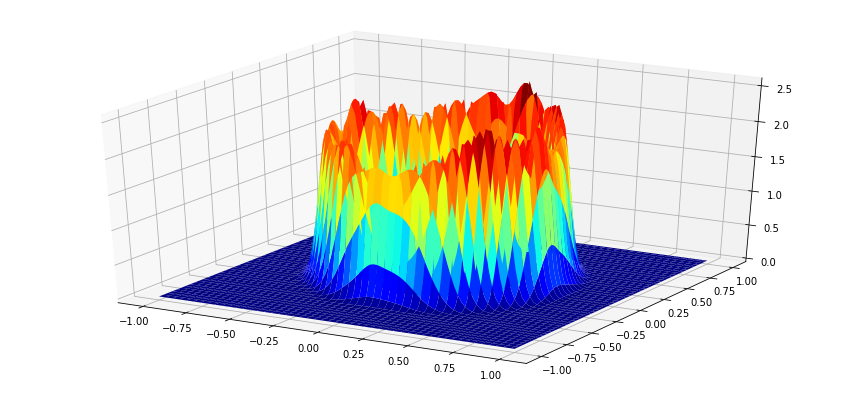

In [48]:
fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(1,1,1,projection="3d")
ax.plot_surface(xgrid, ygrid, zgrid, cmap="jet")
plt.show()

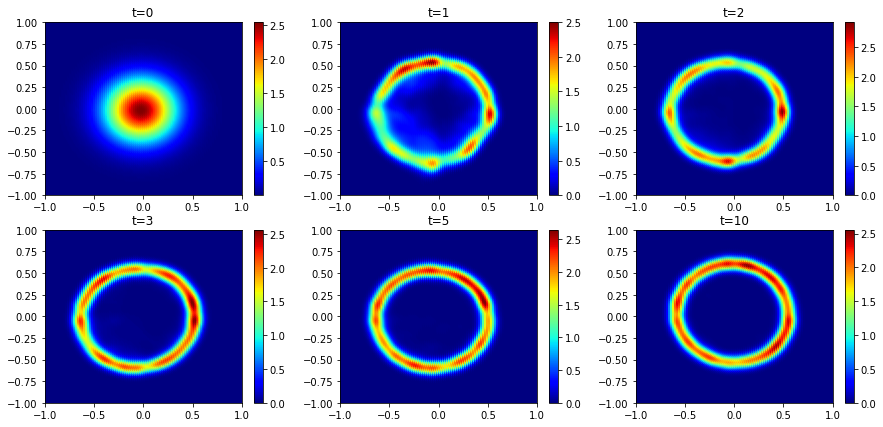

In [21]:
ts=[0,1,2,3,5,10]
fig, ax = plt.subplots(2,3,figsize=(15,7))

xline = torch.linspace(xmin, xmax, 100)
yline = torch.linspace(ymin, ymax, 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for ind,t in enumerate(ts):
    i = ind//3
    j = ind%3

    k = int(t*(len(Lrho)-1)/t_end)

    if k>0:
        z = torch.randn(10000, 2, device=device)
        x = Lrho[k](z)

        kernel = gaussian_kde(x.T.detach().cpu())
        kernel.set_bandwidth(0.125)
        
        zz = kernel.pdf(xyinput.T)
        zgrid = zz.reshape(100, 100)
    else:
        zz = Lrho[0].log_prob(xyinput.to(device)).exp().cpu().detach().numpy()

    zgrid = zz.reshape(100,100)

    cb = ax[i,j].scatter(xgrid, ygrid, c=zgrid,cmap="jet")
    fig.colorbar(cb, ax=ax[i,j])
    ax[i,j].set_title("t="+str(t))
    ax[i,j].set_xlim(xmin, xmax)
    ax[i,j].set_ylim(ymin, ymax)

plt.show()

In [8]:
def plot_F(Lrho, J, device, d=2, n_samples=1000, t_init=0, t_end=4):
    L = []

    for i in range(len(Lrho)):
        if i>0:
            L.append(J(Lrho[i]).item())
        else:           
            x_1 = Lrho[0].sample((n_samples,))
            x_2 = Lrho[0].sample((n_samples,))

            ws = W(x_1-x_2[:,None])
            L.append(torch.mean(ws)/2)

    absc = np.linspace(t_init, t_end, len(L))
    plt.plot(absc, L)
    plt.xlabel("t")
    plt.ylabel(r"$F(\hat{\rho}_t)$")
    plt.show()

No handles with labels found to put in legend.


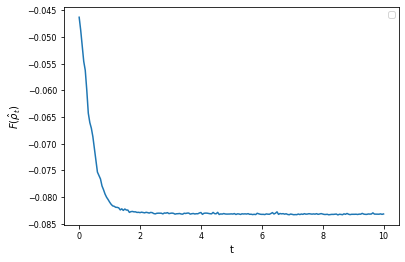

In [9]:
plot_F(Lrho, J, device, t_end=t_end)

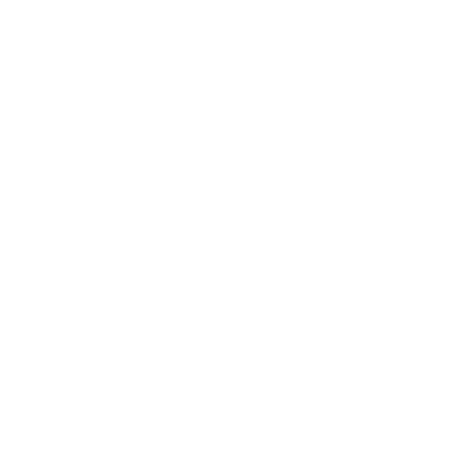

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
camera = Camera(fig)

for i, rho in enumerate(Lrho):
    if i>0:
        z = torch.randn(1000, 2, device=device)
        x = rho(z)
    else:
        x = rho.sample((1000,))
    
    ax.scatter(x[:,0].detach().cpu(), x[:,1].detach().cpu(), c="black")
    ax.axis('off')
    camera.snap()

animation = camera.animate()

In [7]:
HTML(animation.to_html5_video())


A second interaction kernel used is
\begin{equation}
    W(x)=\frac{\|x\|^2}{2}-\log(\|x\|).
\end{equation}

We also observe that the steady state in this case is an indicator function on the disk of radius 1 and centered at the origin.

In [10]:
def W(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    return norm_x**2/2 - torch.log(norm_x)


def J(rho):
    z_1 = torch.randn(1000, 2, device=device)
    z_2 = torch.randn(1000, 2, device=device)
    
    x_1 = rho(z_1)
    x_2 = rho(z_2)
    
    ws = W(x_1-x_2[:,None])
    return torch.mean(ws)/2

In [11]:
t_init = 0
t_end = 3
h = 0.05

n_steps = int(np.ceil((t_end-t_init)/h))

d = 2

mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
sigma0 = torch.tensor(0.25**2 * np.eye(2),device=device,dtype=torch.float)
rho_0 = MultivariateNormal(mu0,sigma0)

lrs = 1e-4 * np.ones(n_steps)
lrs[0] = 5e-3

Lrho = SWGF(rho_0, h, n_step=n_steps, n_epochs=400, 
            J=J, create_nn=mlp, nh=64, nl=5, lrs=lrs, 
            num_projections=1000, n_samples=1024, 
            plot_loss=False, tqdm_bar=True)

In [6]:
z = torch.randn(10000, 2, device=device)
x = Lrho[-1](z)

kernel = gaussian_kde(x.T.detach().cpu())


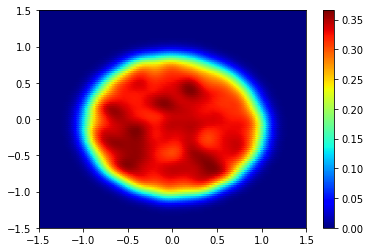

In [7]:
xmin, xmax, ymin, ymax = -1.5, 1.5, -1.5, 1.5

xline = np.linspace(xmin, xmax, 100)
yline = np.linspace(ymin, ymax, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],axis=1)

zz = kernel.pdf(xyinput.T)
zgrid = zz.reshape(100, 100)

plt.scatter(xyinput[:,0], xyinput[:,1], c=zz, cmap="jet")
plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

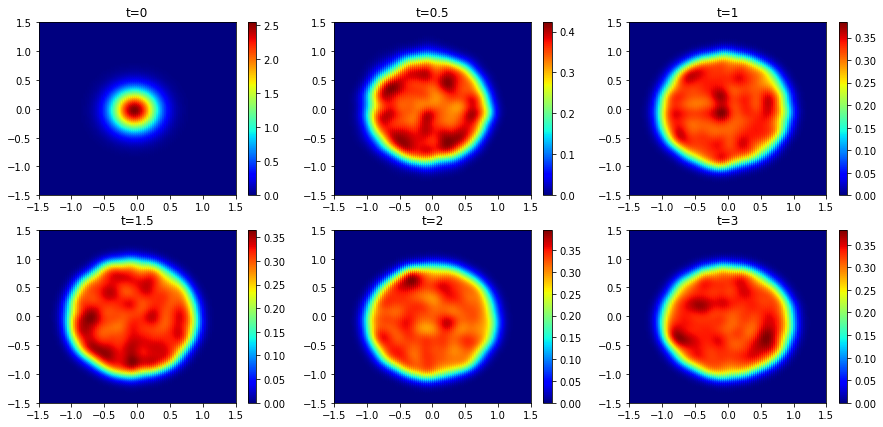

In [8]:
ts=[0,0.5,1,1.5,2,3]
fig, ax = plt.subplots(2,3,figsize=(15,7))

xline = torch.linspace(xmin, xmax, 100)
yline = torch.linspace(ymin, ymax, 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for ind,t in enumerate(ts):
    i = ind//3
    j = ind%3

    k = int(t*(len(Lrho)-1)/t_end)

    if k>0:
        z = torch.randn(10000, 2, device=device)
        x = Lrho[k](z)

        kernel = gaussian_kde(x.T.detach().cpu())
        
        zz = kernel.pdf(xyinput.T)
        zgrid = zz.reshape(100, 100)
    else:
        zz = Lrho[0].log_prob(xyinput.to(device)).exp().cpu().detach().numpy()

    zgrid = zz.reshape(100,100)

    cb = ax[i,j].scatter(xgrid, ygrid, c=zgrid,cmap="jet")
    fig.colorbar(cb, ax=ax[i,j])
    ax[i,j].set_title("t="+str(t))
    ax[i,j].set_xlim(xmin, xmax)
    ax[i,j].set_ylim(ymin, ymax)

plt.show()

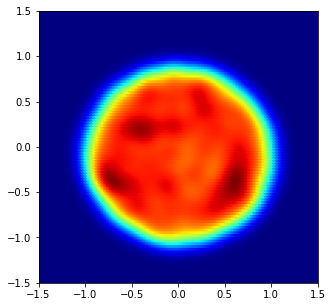

In [9]:
xmin, xmax, ymin, ymax = -1.5, 1.5, -1.5, 1.5

xline = np.linspace(xmin, xmax, 100)
yline = np.linspace(ymin, ymax, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],axis=1)

zz = kernel.pdf(xyinput.T)
zgrid = zz.reshape(100, 100)

plt.figure(figsize=(5,5))
plt.scatter(xyinput[:,0], xyinput[:,1], c=zz, cmap="jet")
# plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

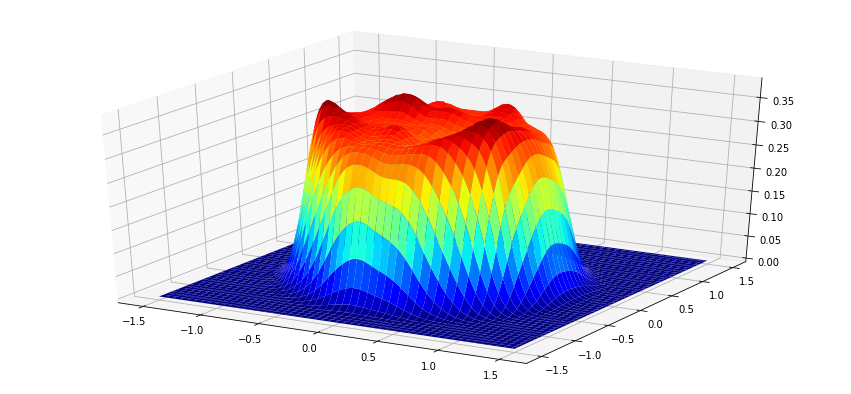

In [11]:
fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(1,1,1,projection="3d")
ax.plot_surface(xgrid, ygrid, zgrid, cmap="jet") #, c=zz)
# ax.view_init(elev=0) #, azim=260)
plt.show()

No handles with labels found to put in legend.


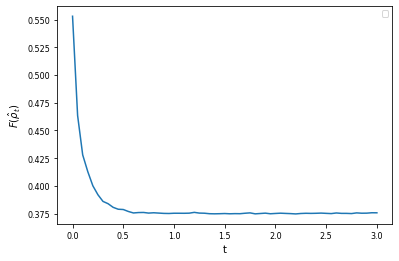

In [12]:
def plot_F(Lrho, J, device, d=2, n_samples=1000, t_init=0, t_end=4):
    L = []

    for i in range(len(Lrho)):
        if i>0:
            L.append(J(Lrho[i]).item())
        else:           
            x_1 = Lrho[0].sample((n_samples,))
            x_2 = Lrho[0].sample((n_samples,))

            ws = W(x_1-x_2[:,None])
            L.append(torch.mean(ws)/2)

    absc = np.linspace(t_init, t_end, len(L))
    plt.plot(absc, L) #, label=r"$F(\hat{\rho}_t)$")
    plt.ylabel(r"$F(\hat{\rho}_t)$")
    plt.xlabel("t")
#     plt.legend()
    plt.show()
    
    np.savetxt("F_disk_MLP", L, delimiter=",")

plot_F(Lrho, J, device, t_end=t_end)

### Aggregation-Drift Equation

By using a functional of the form
\begin{equation}
    J(\rho)=\mathcal{W}(\rho) + \int V(x)\rho(x)\mathrm{d}x,
\end{equation}
we obtained an aggregation-drift equation
\begin{equation}
    \frac{\partial\rho_t}{\partial t}=\mathrm{div}(\rho\nabla(W*\rho))+\mathrm{div}(\rho\nabla V)
\end{equation}

Using the same functionals as in [1], we try
\begin{equation}
    W(x)=\frac{\|x\|^2}{2}-\log(\|x\|)
\end{equation}
and 
\begin{equation}
    V(x) = -\frac{\alpha}{\beta}\log(\|x\|)
\end{equation}
with $\alpha=1$ and $\beta=4$.

Then, the steady state is supposed to be a characteristic(/indicator?) function on a torus with inner and outer radius given by $R_i=\sqrt{\frac{\alpha}{\beta}}$ and $R_o=\sqrt{\frac{\alpha}{\beta}+1}$.

In [13]:
def W(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    return norm_x**2/2 - torch.log(norm_x)

def V(x):
    norm_x = torch.linalg.norm(x, dim=-1)
    return -torch.log(norm_x)/4
    
def J(rho):
    z_1 = torch.randn(1000, 2, device=device)
    z_2 = torch.randn(1000, 2, device=device)
    z_3 = torch.randn(1000, 2, device=device)
    
    x_1 = rho(z_1)
    x_2 = rho(z_2)
    x_3 = rho(z_3)
    
    ws = W(x_1-x_2[:,None])
    return torch.mean(ws)/2 + torch.mean(V(x_3))

In [23]:
d = 2

t_init = 0
t_end = 4
h = 0.1/d

n_steps = int(np.ceil((t_end-t_init)/h))

mu0 = torch.tensor(np.array([0,0]),device=device,dtype=torch.float)
sigma0 = torch.tensor(0.25**2 * np.eye(2),device=device,dtype=torch.float)
rho_0 = MultivariateNormal(mu0,sigma0)

lrs = 1e-4 * np.ones(n_steps)
lrs[0] = 5e-3

Lrho = SWGF(rho_0, h, n_step=n_steps, n_epochs=400, 
            J=J, create_nn=mlp, nh=128, nl=5, lrs=lrs, 
            num_projections=1000, n_samples=1024, 
            plot_loss=False, tqdm_bar=True)

In [20]:
z = torch.randn(10000, 2, device=device)
x = Lrho[-1](z)

kernel = gaussian_kde(x.T.detach().cpu())

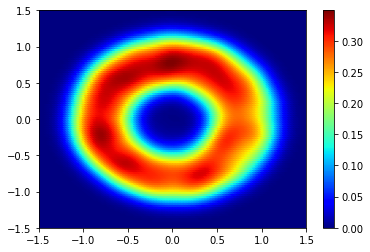

In [57]:
xmin, xmax, ymin, ymax = -1.5, 1.5, -1.5, 1.5

xline = np.linspace(xmin, xmax, 100)
yline = np.linspace(ymin, ymax, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],axis=1)

zz = kernel.pdf(xyinput.T)
zgrid = zz.reshape(100, 100)

plt.scatter(xyinput[:,0], xyinput[:,1], c=zz, cmap="jet")
plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

In [58]:
kernel.factor

0.2154434690031884

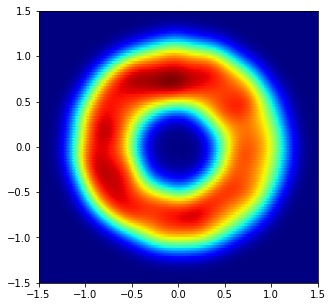

In [48]:
xmin, xmax, ymin, ymax = -1.5, 1.5, -1.5, 1.5

xline = np.linspace(xmin, xmax, 100)
yline = np.linspace(ymin, ymax, 100)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],axis=1)

zz = kernel.pdf(xyinput.T)
zgrid = zz.reshape(100, 100)

plt.figure(figsize=(5,5))
plt.scatter(xyinput[:,0], xyinput[:,1], c=zz, cmap="jet")
# plt.colorbar()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

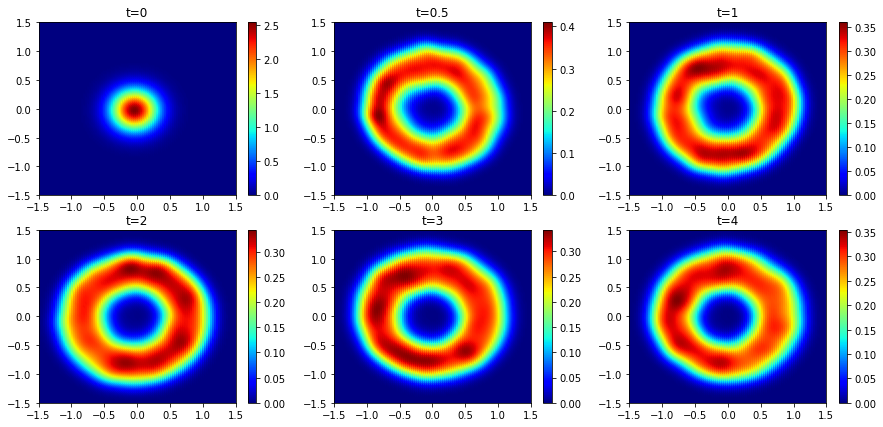

In [40]:
ts=[0,0.5,1,2,3,4]
fig, ax = plt.subplots(2,3,figsize=(15,7))

xline = torch.linspace(xmin, xmax, 100)
yline = torch.linspace(ymin, ymax, 100)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

for ind,t in enumerate(ts):
    i = ind//3
    j = ind%3

    k = int(t*(len(Lrho)-1)/t_end)

    if k>0:
        z = torch.randn(10000, 2, device=device)
        x = Lrho[k](z)

        kernel = gaussian_kde(x.T.detach().cpu())
        
        zz = kernel.pdf(xyinput.T)
        zgrid = zz.reshape(100, 100)
    else:
        zz = Lrho[0].log_prob(xyinput.to(device)).exp().cpu().detach().numpy()

    zgrid = zz.reshape(100,100)

    cb = ax[i,j].scatter(xgrid, ygrid, c=zgrid,cmap="jet")
    fig.colorbar(cb, ax=ax[i,j])
    ax[i,j].set_title("t="+str(t))
    ax[i,j].set_xlim(xmin, xmax)
    ax[i,j].set_ylim(ymin, ymax)

plt.show()

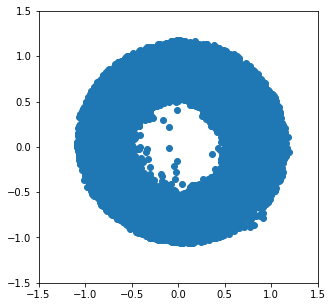

In [49]:
plt.figure(figsize=(5,5))
plt.scatter(x.detach().cpu()[:,0], x.detach().cpu()[:,1])
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

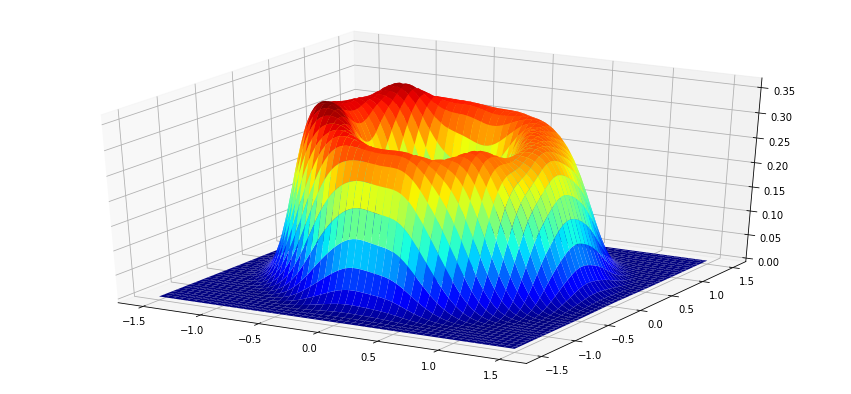

In [55]:
fig = plt.figure(figsize=(15,7))

ax = fig.add_subplot(1,1,1,projection="3d")
ax.plot_surface(xgrid, ygrid, zgrid, cmap="jet") #, c=zz)
# ax.view_init(elev=0) #, azim=260)
plt.show()

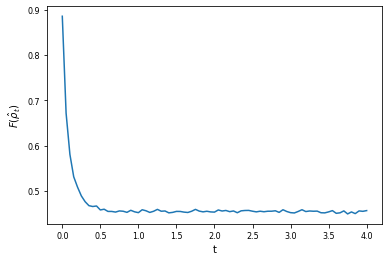

In [25]:
def plot_F(Lrho, J, device, d=2, n_samples=1000, t_init=0, t_end=4):
    L = []

    for i in range(len(Lrho)):
        if i>0:
            L.append(J(Lrho[i]).item())
        else:           
            x_1 = Lrho[0].sample((n_samples,))
            x_2 = Lrho[0].sample((n_samples,))
            x_3 = Lrho[0].sample((n_samples,))

            ws = W(x_1-x_2[:,None])
            L.append(torch.mean(ws)/2+torch.mean(V(x_3)))

    absc = np.linspace(t_init, t_end, len(L))
    plt.plot(absc, L) #, label=r"$F(\hat{\rho}_t)$")
    plt.ylabel(r"$F(\hat{\rho}_t)$")
    plt.xlabel("t")
#     plt.legend()
    plt.show()
    
    np.savetxt("F_drift_MLP", L, delimiter=",")

plot_F(Lrho, J, device, t_end=t_end)

[1] Carrillo, J. A., Craig, K., Wang, L., & Wei, C. (2021). Primal dual methods for Wasserstein gradient flows. Foundations of Computational Mathematics, 1-55.